# Description:

    Investigate Core microbiome of different groups of samples
    Note: log2fold change file was run on Full-Sparsity3in3



# Setting variables

In [1]:

log2foldFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/bare-plant.csv'


# Init

In [2]:

%load_ext rpy2.ipython

In [3]:
%%R
library(vegan)
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(VennDiagram)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permute

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattice

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: This is vegan 2.3-5

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = supe

# Explore DeSeq output to define core microbiomes

### Read DeSeq output

In [4]:
%%R -i log2foldFile
l2f = read.csv(log2foldFile, header = TRUE)
colnames(l2f)

 [1] "log2FoldChange" "p"              "Rank1"          "Rank2"         
 [5] "Rank3"          "Rank4"          "Rank5"          "Rank6"         
 [9] "Rank7"          "Rank8"          "OTU"            "Day"           
[13] "Plant"          "p.adj"         


In [5]:
%%R
l2f.sig = l2f[l2f$p.adj < .05,]
dim(l2f.sig)

[1] 8597   14


In [6]:
%%R
min(l2f.sig$log2FoldChange)

[1] 0.9609501


### Spread by plant to make matrix of log2fold change in each OTU by plant combo

In [7]:
%%R
df = l2f.sig[,c(1,11,13)]
l2f_m = spread(df, Plant, log2FoldChange, fill = 0, drop = TRUE)
l2f_m %>% head

        OTU   75-062    ABUTH    AMAPO      B73      B97    ECHCG    ELCOR
1    OTU.10 3.755553 3.554574 3.913238 4.730054 3.983959 4.116643 3.242262
2   OTU.100 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
3  OTU.1000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
4 OTU.10009 0.000000 0.000000 4.848621 5.219825 0.000000 0.000000 6.751878
5  OTU.1001 0.000000 0.000000 0.000000 6.053131 6.493816 0.000000 0.000000
6 OTU.10030 0.000000 0.000000 2.353137 0.000000 0.000000 0.000000 0.000000
     ERATE    FAGES    GLYMA      H99    HELAN    Hp301    Il14H      Ki3
1 3.998816 2.226031 4.493125 2.409564 2.879535 4.408774 4.349912 4.357638
2 0.000000 1.042526 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
3 0.000000 1.939025 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
4 5.927989 0.000000 4.524680 0.000000 0.000000 0.000000 0.000000 0.000000
5 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
6 0.000000 4.359155 0.000000 0.

In [8]:
%%R
dim(l2f_m) %>% print

matrix.please<-function(x) {
    m<-as.matrix(x[,-1])
    rownames(m)<-x[,1]
    m
}
l2f_mat = matrix.please(l2f_m)
head(l2f_mat)

[1] 1506   23
            75-062    ABUTH    AMAPO      B73      B97    ECHCG    ELCOR
OTU.10    3.755553 3.554574 3.913238 4.730054 3.983959 4.116643 3.242262
OTU.100   0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.1000  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.10009 0.000000 0.000000 4.848621 5.219825 0.000000 0.000000 6.751878
OTU.1001  0.000000 0.000000 0.000000 6.053131 6.493816 0.000000 0.000000
OTU.10030 0.000000 0.000000 2.353137 0.000000 0.000000 0.000000 0.000000
             ERATE    FAGES    GLYMA      H99    HELAN    Hp301    Il14H
OTU.10    3.998816 2.226031 4.493125 2.409564 2.879535 4.408774 4.349912
OTU.100   0.000000 1.042526 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.1000  0.000000 1.939025 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.10009 5.927989 0.000000 4.524680 0.000000 0.000000 0.000000 0.000000
OTU.1001  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.10030 0.000000 4.359155 0.000000 

## Ordinate significant log two-fold change

In [9]:
%%R
bc = vegdist(t(l2f_mat), method="bray", binary=TRUE)


In [10]:
%%R
ord <- metaMDS(bc)

Run 0 stress 0.1240072 
Run 1 stress 0.1240069 
... New best solution
... procrustes: rmse 0.0002298014  max resid 0.0008410543 
*** Solution reached


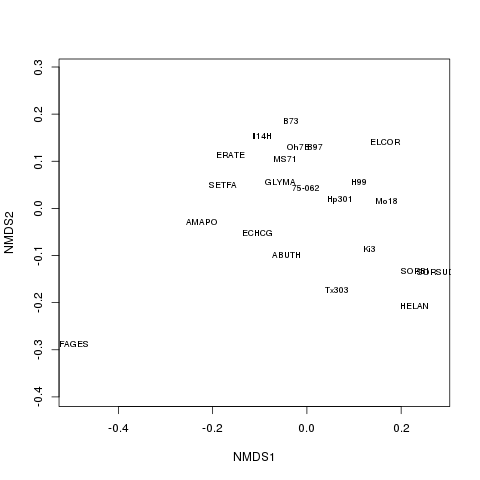

In [11]:
%%R
plot(ord, type = "t")

In [12]:
%%R
pdf(file = "/home/bryan/RhizCG/figures/l2fCluster.pdf")
CL <- hclust(bc, method="average")
CL
plot(CL, main = "Cluster Dendrogram of l2f \n Bray-Curtis Distances")
dev.off()

png 
  2 


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘ape’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:VennDiagram’:

    rotate


  res = super(Function, self).__call__(*new_args, **new_kwargs)


$type
[1] "phylogram"

$use.edge.length
[1] TRUE

$node.pos
[1] 1

$node.depth
[1] 1

$show.tip.label
[1] TRUE

$show.node.label
[1] FALSE

$font
[1] 3

$cex
[1] 1

$adj
[1] 0

$srt
[1] 0

$no.margin
[1] FALSE

$label.offset
[1] 0

$x.lim
[1] 0.0000000 0.4229338

$y.lim
[1]  1 22

$direction
[1] "rightwards"

$tip.color
numeric(0)

$Ntip
[1] 22

$Nnode
[1] 21

$root.time
NULL

$align.tip.label
[1] FALSE



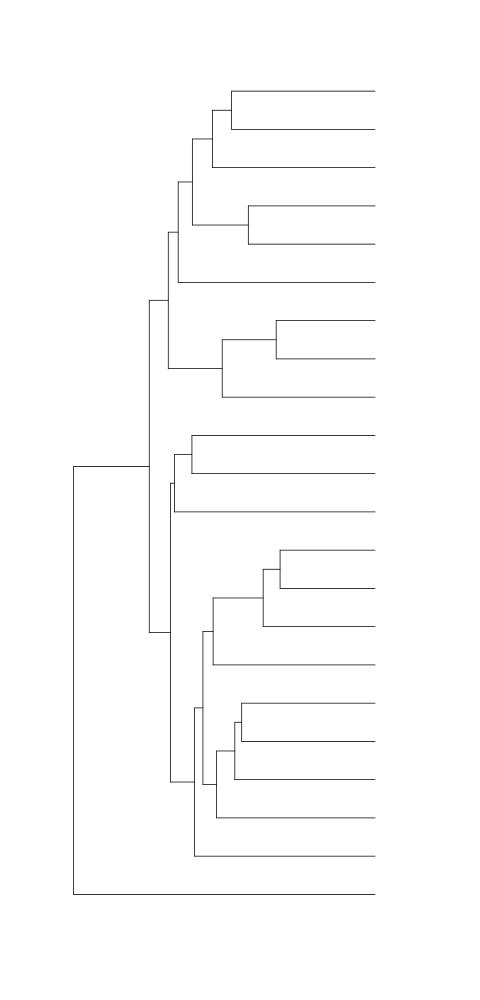

In [13]:
%%R -h 1000
library(ape)
Var = l2f.sig$Day  %>% levels # factor variable for colors
result_phylo <- as.phylo(CL)
p = plot(result_phylo, tip.col = as.numeric(as.character(Var)))
p

## Define l2f cores by group

### Core rhizosphere (all plants)

In [14]:
%%R


rc_sel = apply(l2f_mat, 1,function (x) min(x) > 0)
   
l2f_rhizcore = l2f_mat[rc_sel,]    
Allcore = dim(unique(l2f_rhizcore))[1]
Allcore

[1] 31


Rhizosphere Core: 31 OTUs significantly enriched in all rhizospheres

### Maize

In [15]:
%%R
colnames(l2f_mat)
head(l2f_mat)

            75-062    ABUTH    AMAPO      B73      B97    ECHCG    ELCOR
OTU.10    3.755553 3.554574 3.913238 4.730054 3.983959 4.116643 3.242262
OTU.100   0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.1000  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.10009 0.000000 0.000000 4.848621 5.219825 0.000000 0.000000 6.751878
OTU.1001  0.000000 0.000000 0.000000 6.053131 6.493816 0.000000 0.000000
OTU.10030 0.000000 0.000000 2.353137 0.000000 0.000000 0.000000 0.000000
             ERATE    FAGES    GLYMA      H99    HELAN    Hp301    Il14H
OTU.10    3.998816 2.226031 4.493125 2.409564 2.879535 4.408774 4.349912
OTU.100   0.000000 1.042526 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.1000  0.000000 1.939025 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.10009 5.927989 0.000000 4.524680 0.000000 0.000000 0.000000 0.000000
OTU.1001  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.10030 0.000000 4.359155 0.000000 0.000000 0.000

In [16]:
%%R
maize_mat = l2f_mat[,c("75-062", "B73", "B97", "H99","Hp301",  "Il14H",  "Ki3", "Mo18", "MS71", 
                       "Oh7B", "Tx303")] 

c_sel = apply(maize_mat, 1,function (x) min(x) > 0)
   
l2f_maizecore = as.data.frame(maize_mat[c_sel,])   
Maizecore = dim(l2f_maizecore)[1]  
    Maizecore
dummy = rep(1, dim(l2f_maizecore)[1])
OTU = row.names(l2f_maizecore)
MCT = OTU

length(unique(MCT )) 

[1] 103


Maize Core Rhizosphere: 103 OTUs consistently enriched

## C4 grasses not including maize

In [17]:
%%R
C4.nm_mat = l2f_mat[,c("ECHCG",  "ELCOR",  "ERATE", "SETFA",  "SORBI",  "SORSUD")] 

c_sel = apply(C4.nm_mat, 1,function (x) min(x) > 0)
   
l2f_C4.nmcore = as.data.frame(C4.nm_mat[c_sel,])    
C4core = dim(l2f_C4.nmcore)[1]   
OTU = row.names(l2f_C4.nmcore)
dummy = rep(1, dim(l2f_C4.nmcore)[1])
CCT = OTU

CCT  

 [1] "OTU.10"    "OTU.10253" "OTU.10288" "OTU.1034"  "OTU.10692" "OTU.108"  
 [7] "OTU.11012" "OTU.11069" "OTU.112"   "OTU.114"   "OTU.120"   "OTU.12012"
[13] "OTU.1243"  "OTU.125"   "OTU.134"   "OTU.137"   "OTU.15"    "OTU.152"  
[19] "OTU.1628"  "OTU.188"   "OTU.189"   "OTU.194"   "OTU.196"   "OTU.207"  
[25] "OTU.2285"  "OTU.23"    "OTU.24"    "OTU.260"   "OTU.2703"  "OTU.284"  
[31] "OTU.293"   "OTU.297"   "OTU.304"   "OTU.307"   "OTU.321"   "OTU.354"  
[37] "OTU.393"   "OTU.4"     "OTU.4049"  "OTU.407"   "OTU.414"   "OTU.42"   
[43] "OTU.422"   "OTU.4340"  "OTU.4378"  "OTU.440"   "OTU.4513"  "OTU.4888" 
[49] "OTU.49"    "OTU.4954"  "OTU.528"   "OTU.53"    "OTU.5436"  "OTU.556"  
[55] "OTU.57"    "OTU.673"   "OTU.68"    "OTU.7"     "OTU.712"   "OTU.7313" 
[61] "OTU.75"    "OTU.7874"  "OTU.795"   "OTU.8"     "OTU.81"    "OTU.9"    
[67] "OTU.9377"  "OTU.9421"  "OTU.9501"  "OTU.96"    "OTU.976"  


### C4 grasses including maize

In [18]:
%%R
C4_mat = l2f_mat[,c("75-062", "B73", "B97", "H99","Hp301",  "Il14H",  "Ki3", "Mo18", "MS71", 
                       "Oh7B", "Tx303", "ECHCG",  "ELCOR",  "ERATE", "SETFA",  "SORBI",  "SORSUD")] 

c_sel = apply(C4_mat, 1,function (x) min(x) > 0)
   
l2f_C4core = C4_mat[c_sel,]    
 dim(l2f_C4core)[1] 


 

[1] 50


### Chloridoideae subfamily

In [65]:
%%R
Chloridoideae.mat = l2f_mat[, c("ERATE", "ELCOR")]

c_sel = apply(Chloridoideae.mat, 1,function (x) min(x) > 0)
    Chloridoideae.core = Chloridoideae.mat[c_sel,]    
 dim(Chloridoideae.core)[1]

ChCT = cbind(row.names( Chloridoideae.core), rep(1, length(row.names(Chloridoideae.core)))) %>% as.data.frame
    colnames(ChCT) = c("OTU", "ChloridoideaeCore")
    ChCT

          OTU ChloridoideaeCore
1      OTU.10                 1
2   OTU.10009                 1
3   OTU.10219                 1
4   OTU.10253                 1
5   OTU.10288                 1
6   OTU.10329                 1
7    OTU.1034                 1
8    OTU.1039                 1
9     OTU.104                 1
10  OTU.10442                 1
11  OTU.10472                 1
12  OTU.10520                 1
13  OTU.10604                 1
14  OTU.10692                 1
15   OTU.1070                 1
16  OTU.10763                 1
17    OTU.108                 1
18   OTU.1092                 1
19   OTU.1098                 1
20  OTU.11012                 1
21  OTU.11069                 1
22    OTU.112                 1
23   OTU.1123                 1
24  OTU.11302                 1
25    OTU.114                 1
26    OTU.117                 1
27    OTU.120                 1
28  OTU.12012                 1
29  OTU.12023                 1
30   OTU.1207                 1
31  OTU.

### Panicoideae subfamily 

In [64]:
%%R
Panicoideae.mat = l2f_mat[, c("75-062", "B73", "B97", "H99","Hp301",  "Il14H",  "Ki3", "Mo18", "MS71", 
                       "Oh7B", "Tx303", "SETFA", "ECHCG", "SORSUD", "SORBI")]

c_sel = apply(Panicoideae.mat, 1,function (x) min(x) > 0)
    Panicoideae.core = Panicoideae.mat[c_sel,]    
 dim(Panicoideae.core)[1]
     dim(Panicoideae.core)[1]
        PCT = cbind(row.names( Panicoideae.core), rep(1, length(row.names(Panicoideae.core)))) %>% as.data.frame
    colnames(PCT) = c("OTU", "PanicoideaeCore")
    PCT

         OTU PanicoideaeCore
1     OTU.10               1
2  OTU.10253               1
3  OTU.10288               1
4   OTU.1034               1
5  OTU.10692               1
6    OTU.108               1
7  OTU.11012               1
8  OTU.11069               1
9    OTU.114               1
10   OTU.120               1
11 OTU.12012               1
12  OTU.1243               1
13   OTU.125               1
14   OTU.134               1
15   OTU.137               1
16    OTU.15               1
17   OTU.152               1
18   OTU.188               1
19   OTU.189               1
20   OTU.196               1
21  OTU.2000               1
22   OTU.207               1
23    OTU.23               1
24    OTU.24               1
25  OTU.2703               1
26   OTU.277               1
27   OTU.284               1
28   OTU.293               1
29   OTU.304               1
30   OTU.307               1
31   OTU.321               1
32  OTU.3548               1
33  OTU.3910               1
34     OTU.4  

## Panicoideae/Paniceae

In [63]:
%%R
Paniceae.mat = l2f_mat[, c("ECHCG", "SETFA")]

c_sel = apply(Paniceae.mat, 1,function (x) min(x) > 0)
    Paniceae.core = Paniceae.mat[c_sel,]    
 dim(Paniceae.core)[1]
        P_PCT = cbind(row.names( Paniceae.core), rep(1, length(row.names(Paniceae.core)))) %>% as.data.frame
    colnames(P_PCT) = c("OTU", "PaniceaeCore")
    P_PCT

          OTU PaniceaeCore
1      OTU.10            1
2     OTU.101            1
3   OTU.10221            1
4   OTU.10249            1
5   OTU.10253            1
6   OTU.10288            1
7    OTU.1034            1
8    OTU.1039            1
9   OTU.10692            1
10   OTU.1073            1
11  OTU.10763            1
12   OTU.1078            1
13    OTU.108            1
14   OTU.1092            1
15   OTU.1094            1
16  OTU.10966            1
17  OTU.11012            1
18  OTU.11069            1
19    OTU.112            1
20    OTU.114            1
21   OTU.1141            1
22   OTU.1149            1
23  OTU.11804            1
24   OTU.1195            1
25  OTU.11995            1
26    OTU.120            1
27  OTU.12012            1
28    OTU.123            1
29   OTU.1233            1
30  OTU.12373            1
31   OTU.1242            1
32   OTU.1243            1
33    OTU.125            1
34  OTU.12628            1
35   OTU.1272            1
36   OTU.1279            1
3

## Panicoideae/Anropogoneae


In [61]:
%%R
Andropogoneae.mat = l2f_mat[, c("75-062", "B73", "B97", "H99","Hp301",  "Il14H",  "Ki3", "Mo18", "MS71", 
                       "Oh7B", "Tx303", "SORSUD", "SORBI")]

c_sel = apply(Andropogoneae.mat, 1,function (x) min(x) > 0)
    Andropogoneae.core = Andropogoneae.mat[c_sel,]    
 dim(Andropogoneae.core)[1]
    Andropogoneae.core
    ACT = cbind(row.names( Andropogoneae.core), rep(1, length(row.names(Andropogoneae.core)))) %>% as.data.frame
    colnames(ACT) = c("OTU", "AndropogoneaeCore")
    ACT

         OTU AndropogoneaeCore
1     OTU.10                 1
2  OTU.10253                 1
3  OTU.10288                 1
4   OTU.1034                 1
5    OTU.104                 1
6  OTU.10472                 1
7  OTU.10692                 1
8    OTU.108                 1
9   OTU.1098                 1
10 OTU.11012                 1
11 OTU.11069                 1
12   OTU.114                 1
13   OTU.120                 1
14 OTU.12012                 1
15 OTU.12414                 1
16  OTU.1243                 1
17   OTU.125                 1
18   OTU.134                 1
19   OTU.137                 1
20    OTU.15                 1
21   OTU.152                 1
22   OTU.188                 1
23   OTU.189                 1
24   OTU.196                 1
25   OTU.197                 1
26   OTU.200                 1
27  OTU.2000                 1
28   OTU.202                 1
29   OTU.207                 1
30    OTU.23                 1
31    OTU.24                 1
32    OT

### Dicots

In [19]:
%%R
Dicot_mat = l2f_mat[,c("AMAPO", "ABUTH", "FAGES", "HELAN", "GLYMA")] 

c_sel = apply(Dicot_mat, 1,function (x) min(x) > 0)
   
l2f_Dicotcore = Dicot_mat[c_sel,]    
Dicotcore = dim(l2f_Dicotcore)[1] 
dummy = rep(1, dim(l2f_Dicotcore)[1])
OTU = row.names(l2f_Dicotcore)
DCT = OTU
#colnames(DCT) = c("OTU", "dummy")
DCT

 [1] "OTU.10"    "OTU.10249" "OTU.10253" "OTU.10288" "OTU.1034"  "OTU.104"  
 [7] "OTU.10472" "OTU.108"   "OTU.11012" "OTU.11069" "OTU.112"   "OTU.114"  
[13] "OTU.12023" "OTU.1242"  "OTU.1243"  "OTU.134"   "OTU.1403"  "OTU.152"  
[19] "OTU.162"   "OTU.1628"  "OTU.173"   "OTU.189"   "OTU.194"   "OTU.196"  
[25] "OTU.200"   "OTU.207"   "OTU.2285"  "OTU.24"    "OTU.260"   "OTU.284"  
[31] "OTU.293"   "OTU.336"   "OTU.3910"  "OTU.4"     "OTU.4049"  "OTU.406"  
[37] "OTU.414"   "OTU.4340"  "OTU.4423"  "OTU.4513"  "OTU.4888"  "OTU.49"   
[43] "OTU.536"   "OTU.5436"  "OTU.641"   "OTU.671"   "OTU.68"    "OTU.704"  
[49] "OTU.7259"  "OTU.8"     "OTU.9"     "OTU.9174"  "OTU.9377"  "OTU.9421" 
[55] "OTU.9501"  "OTU.96"   


## Create Venn Diagram

In [20]:
%%R
#Create tables that will be basis of comparisons
#Add OTU
#All plants
A1 = length(MCT) #Maize
A2 = length(CCT) #C4 grasses
A3 = length(DCT) #Dictos
A12 = length(unique(intersect(MCT, CCT)))
A13 = length(unique(intersect(MCT, DCT)))
A23 = length(unique(intersect(CCT, DCT)))
A123 = Allcore
A2

[1] 71


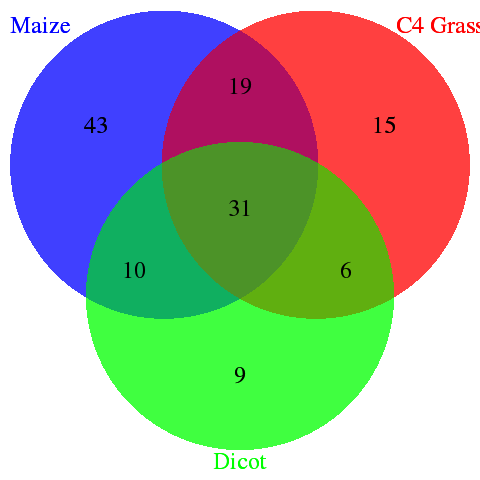

In [21]:
%%R


#Draw venn diagram 
venn.plot <- draw.triple.venn(
area1 = A1,
area2 = A2,
area3 = A3,
n12 = A12,
n23 = A23,
n13 = A13,
n123 = A123,
category = c("Maize", "C4 Grass", "Dicot"),
euler.d = TRUE, 
fill = c("blue", "red", "green"),
lty = "blank",
cex = 2,
cat.cex = 2,
cat.col = c("blue", "red", "green")
);
grid.draw(venn.plot);
grid.newpage();



# area1 = 65,
# area2 = 75,
# area3 = 85,
# n12 = 35,
# n23 = 15,
# n13 = 25,
# n123 = 5,

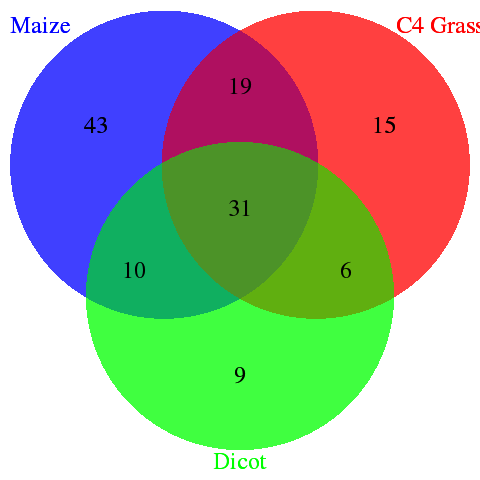

In [22]:
%%R
#Draw venn diagram 
venn.plot <- draw.triple.venn(
area1 = A1,
area2 = A2,
area3 = A3,
n12 = A12,
n23 = A23,
n13 = A13,
n123 = A123,
category = c("Maize", "C4 Grass", "Dicot"),
euler.d = TRUE, 
fill = c("blue", "red", "green"),
lty = "blank",
cex = 2,
cat.cex = 2,
cat.col = c("blue", "red", "green")
);
grid.draw(venn.plot);
grid.newpage();





## Core on a sampling date

### Day 53

In [23]:
%%R
Date_mat = l2f_mat[,c("AMAPO", "ECHCG")] 

c_sel = apply(Date_mat, 1,function (x) min(x) > 0)
   
l2f_dateCore = Dicot_mat[c_sel,]    
dim(l2f_dateCore)   

[1] 233   5


### Day 57

In [24]:
%%R
Date_mat = l2f_mat[,c("GLYMA", "ABUTH")] 

c_sel = apply(Date_mat, 1,function (x) min(x) > 0)
   
l2f_dateCore = Dicot_mat[c_sel,]    
dim(l2f_dateCore)  

[1] 226   5


### Day 72

In [25]:
%%R
Date_mat = l2f_mat[,c("75-062","ERATE","H99","Il14H",  "MS71" )] 

c_sel = apply(Date_mat, 1,function (x) min(x) > 0)
   
l2f_dateCore = Dicot_mat[c_sel,]    
dim(l2f_dateCore) 


[1] 162   5


### Day 79

In [26]:
%%R
Date_mat = l2f_mat[,c("B73" ,  "B97"  , "Hp301", "Oh7B"  )] 

c_sel = apply(Date_mat, 1,function (x) min(x) > 0)
   
l2f_dateCore = Dicot_mat[c_sel,]    
dim(l2f_dateCore) 


[1] 276   5


### Day 84

In [27]:
%%R
Date_mat = l2f_mat[,c("HELAN" , "SORBI" , "SORSUD"  )] 

c_sel = apply(Date_mat, 1,function (x) min(x) > 0)
   
l2f_dateCore = Dicot_mat[c_sel,]    
dim(l2f_dateCore)

[1] 100   5


### Day 88

In [28]:
%%R
Date_mat = l2f_mat[,c("ELCOR", "Ki3" ,  "Mo18" , "Tx303")] 

c_sel = apply(Date_mat, 1,function (x) min(x) > 0)
   
l2f_dateCore = Dicot_mat[c_sel,]    
dim(l2f_dateCore)

[1] 105   5


# Core members

## All rhizosphere core

In [29]:
%%R
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3')
physeq.Full = readRDS(F)
sd = sample_data(physeq.Full)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [30]:
%%R
#Make variable for joining
Taxa = tax_table(physeq.Full) %>% as.data.frame()
Taxa$OTU = row.names(Taxa)
Coretbl = as.data.frame(l2f_rhizcore)
Coretbl$OTU = row.names(Coretbl)

CoreTaxa = inner_join(Coretbl, Taxa)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining by: "OTU"

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [31]:
%%R
CoreTaxa

     75-062    ABUTH    AMAPO      B73      B97    ECHCG    ELCOR    ERATE
1  3.755553 3.554574 3.913238 4.730054 3.983959 4.116643 3.242262 3.998816
2  5.891288 4.852547 6.363949 6.351210 5.331523 5.517604 4.845139 5.770661
3  4.276646 3.085141 3.694847 6.401280 5.676574 3.456203 4.096773 4.102399
4  3.299086 4.204686 4.402033 5.804496 4.685607 2.176160 3.775422 4.560968
5  5.631446 8.378662 7.345840 7.097692 5.431812 6.145990 7.452859 7.363096
6  3.188175 3.288303 3.751331 4.541218 3.735438 2.686601 3.797897 3.177429
7  3.586984 2.491399 3.365728 5.485980 4.020008 3.499923 2.864703 2.844242
8  3.285204 5.306045 3.926893 4.014599 3.433749 4.007883 3.147667 4.432104
9  4.314674 4.757807 3.722280 5.490029 4.592643 3.619629 5.628495 4.056646
10 2.709302 3.181629 2.999717 3.492144 2.774897 2.386902 3.006625 2.679636
11 3.085641 3.787463 4.537547 4.156385 3.258488 4.687530 3.508734 3.110849
12 4.404056 5.411230 4.184066 4.953385 4.198393 5.186166 4.203979 5.636966
13 4.643349 7.799628 5.23

## Any core

In [92]:
%%R
# collect three core groups: Maize, C4 grasses, Dicots
#c(DCT, MCT, CCT) %>% unique
DicotTbl = cbind(DCT, as.numeric(rep(1,length(DCT)))) %>% as.data.frame
colnames(DicotTbl) = c("OTU", "DicotCore")
DicotTbl

MaizeTbl = cbind(MCT, rep(1,length(MCT))) %>% as.data.frame
colnames(MaizeTbl) = c("OTU", "MaizeCore")
MaizeTbl

C4Tbl = cbind(CCT, rep(1,length(CCT))) %>% as.data.frame
colnames(C4Tbl) = c("OTU", "C4Core")
C4Tbl

CoreDF = full_join(MaizeTbl, C4Tbl, by = "OTU")
CoreDF = full_join(CoreDF, DicotTbl, by = "OTU")

CoreDF = full_join(CoreDF, PCT, by = "OTU")
CoreDF = full_join(CoreDF, P_PCT, by = "OTU")
CoreDF = full_join(CoreDF, ACT, by = "OTU")
CoreDF = full_join(CoreDF, ChCT, by = "OTU")

CoreDF

write.csv(CoreDF, file = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTUexploration/CoreTaxa.csv')